<a href="https://colab.research.google.com/github/sriharsha1718/LangGraph/blob/main/08_ReAct_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q langchain_groq

In [2]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

In [3]:
GROQ_API_KEY = 'gsk_xxxxxxxxxxxxxxxxxxxxx'

In [4]:
class AgentState(TypedDict):
  messages : Annotated[Sequence[BaseMessage], add_messages]

#decorator
@tool
def add(a : int, b : int):
  """This is an addition function"""
  return a + b

@tool
def subtract(a : int, b: int):
  """This is a subtraction function"""
  return a - b

@tool
def multiply(a : int, b : int):
  """This is a multiplication function"""
  return a * b

tools = [add, subtract, multiply]

model = ChatGroq(
    model="llama-3.1-8b-instant", temperature=0,
    api_key=GROQ_API_KEY
).bind_tools(tools)

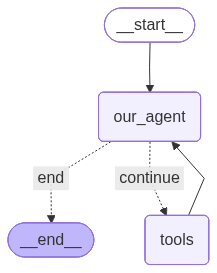

In [5]:
def model_call(state: AgentState) -> AgentState:
  system_prompt = SystemMessage(
      content='You are my assistant, please answer my query to the best of your ability'
  )
  response = model.invoke([system_prompt] + state['messages'])
  return {'messages' : [response]}


def should_continue(state: AgentState):
  messages = state['messages']
  last_message = messages[-1]
  if not last_message.tool_calls:
    return 'end'
  else:
    return 'continue'

graph = StateGraph(AgentState)
graph.add_node('our_agent', model_call)

tool_node = ToolNode(tools=tools)
graph.add_node('tools', tool_node)

graph.add_edge('tools', 'our_agent')

graph.add_edge(START, 'our_agent')
graph.add_conditional_edges(
    'our_agent',
    should_continue,
    {
        'continue' : 'tools' ,
        'end' : END
    }
)


app = graph.compile()

from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
def print_stream(stream):
  for s in stream:
    message = s['messages'][-1]
    if isinstance(message, tuple):
      print(message)
    else:
      message.pretty_print()

inputs = {"messages": [("user", "Add 40 + 12  and then multiply the result by 6. Also tell me a cool joke please.")]}
print_stream(app.stream(inputs, stream_mode='values'))

================================ Human Message =================================

Add 40 + 12  and then multiply the result by 6. Also tell me a cool joke please.
================================== Ai Message ==================================
Tool Calls:
  add (03s4ka3z3)
 Call ID: 03s4ka3z3
  Args:
    a: 40
    b: 12
  multiply (ks5p524sz)
 Call ID: ks5p524sz
  Args:
    a: 52
    b: 6
================================= Tool Message =================================
Name: multiply

312
================================== Ai Message ==================================

Here's a cool joke for you:

What do you call a fake noodle?

An impasta!
